# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
# number of callbacks for black-sounding names
print('black: ',sum(data[data.race=='b'].call))
print('white: ',sum(data[data.race=='w'].call))

black:  157.0
white:  235.0


In [4]:
data.head(3)

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,


<div class="span5 alert alert-success">
<p>
<h1>Answer 1</h1>    
<br>
    The trials (sending a resume, receiving a callback or not) are <b> Bernoulli Trials </b> as they are independent and result in a binary outcome. The data therefore follows a binomial distribution.<br>
    The Central Limit Theorem does not apply, because we are not comparing series of Bernoulli Trials (we are not interested in how many "sets of 4 applications" yield 1, 2, 3 or 4 callbacks).<br>
    To compare two binomial samples we will apply the Chi-Squared 2x2 test (2 categories, 2 outcomes), available as <code>scipy.stats.chi2_contingency</code>.


<h1>Answer 2</h1>
<br>
<b>H0:</b> Call-back rate and name-category are independent variables. Ie. the rate does not differ between white or black names.<br>
<b>H1:</b> Call-back rate and name-category are dependent variables. Ie. the rate differs between white or black names<br>This would be a two-sided test (either rate could be higher than the other).
</p>
</div>

In [5]:
# write logic as definitions to re-use in bootstrapping
def split_w_b(sample):
    '''returns data split as white, black'''
    return sample[sample.race=='w'], sample[sample.race=='b']

def calc_sample_size_and_callback_rate(sample):
    callb = sample[sample.call == 1.0]
    sample_size = len(sample)
    return sample_size, len(callb)/sample_size

w, b = split_w_b(data)

w_callb = len(w[w.call == 1.0])
b_callb = len(b[b.call == 1.0])

sample_size_w, callback_rate_w = calc_sample_size_and_callback_rate(w)
sample_size_b, callback_rate_b = calc_sample_size_and_callback_rate(b)

print(('White callback rate %.1f%%: %.0f calls on a %.0f sample') % (
    callback_rate_w*100, w_callb, sample_size_w))
print(('Black callback rate %.1f%%: %.0f calls on a %.0f sample') % (
    callback_rate_b*100, b_callb, sample_size_b))

White callback rate 9.7%: 235 calls on a 2435 sample
Black callback rate 6.4%: 157 calls on a 2435 sample


In [6]:
# Frequentist approach: Chi-squared 2x2 test.

callbacks = np.array(
    [[w_callb, sample_size_w - w_callb],   #white callback, no callback
     [b_callb, sample_size_b - b_callb]])  #black callback, no callback

chisquared, pvalue, dof, expfreq = stats.chi2_contingency(callbacks)

print('the p-value is %.2f' % pvalue)
if pvalue < 0.05:
    print('the p-value is less than 0.05. REJECT the H0.')
else:
    print('the p-value is more than 0.05. ACCEPT the H0.')

the p-value is 0.00
the p-value is less than 0.05. REJECT the H0.


In [7]:
# Bootstrapping method
# The variable to be analyzed: Difference in Propotions
diff_of_prop_observed = callback_rate_w - callback_rate_b

# Select n replicates of the w and b datasets and store the difference in callback rate.
n = 500
replicates = np.empty(n)

for i in range(n):
    repl_w = w.sample(n=sample_size_w, replace=True)
    repl_b = b.sample(n=sample_size_b, replace=True)
    
    repl_callb_w = calc_sample_size_and_callback_rate(repl_w)[1]
    repl_callb_b = calc_sample_size_and_callback_rate(repl_b)[1]
    
    replicates[i] = repl_callb_w - repl_callb_b
    
p_value = sum(replicates < 0) / n
conf_int_95 = np.percentile(replicates, [2.5, 97.5])
print('the p-value is %.2f and the 95%% confidence interval is' % p_value, conf_int_95)

the p-value is 0.00 and the 95% confidence interval is [0.01662218 0.04722793]


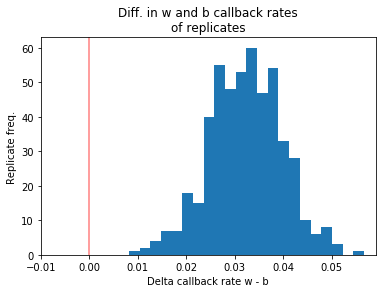

In [9]:
# Plot this distribution
import matplotlib.pyplot as plt

plt.hist(replicates, bins=int(n**0.5))
#plt.plot(replicates, marker='.', linestyle='none', alpha=0.5)
plt.title('Diff. in w and b callback rates\nof replicates')
plt.xlabel('Delta callback rate w - b')
plt.xlim(left=-0.01)
plt.axvline(x=0, color='r', alpha=0.5)
plt.ylabel('Replicate freq.')
plt.show()

<div class="span5 alert alert-success">
<p>
<h1>Answer 3</h1>    
The analysis has been performed using frequentist (Chi-squared) and bootstrapping methods.<br>
<b>Outcome:</b> Both methods indicate that the null-hypothesis is to be rejected.
</div>

<div class="span5 alert alert-success">
<p>
<h1>Answer 4</h1>    
There is a statistically significant difference between the call-back rates experienced by white-sounding and black-sounding job applicants. The difference is about 3 percentage points.
<h1>Answer 5</h1>    
This analysis does not indicate the relative important is this one variable compared to others. The dataset contains many variables. The analysis can be repeates for other categorical variables, and with other methods for continuous variables.
</div>